In [1]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook 
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
%matplotlib inline
from matplotlib import  pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') # игнорировать предупрежединия в красном прямоугольнке

from pathlib2 import Path
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV

In [2]:
PATH_TO_DATA = Path('../data/')

times = ['time%s' % i for i in range(1, 11)]
train_df = pd.read_csv(PATH_TO_DATA / 'train_sessions.csv',
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv(PATH_TO_DATA / 'test_sessions.csv',
                      index_col='session_id', parse_dates=times)

In [3]:
SEED = 17

In [4]:
# перевод колонок time к временному формату
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

In [5]:
# отсортируем данные по времени
train_df = train_df.sort_values(by='time1')
train_df.head(5)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0



Сессии пользователей выделены таким образом, что они не могут быть длиннее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд либо когда сессия заняла по времени более 30 минут.
 
В таблице встречаются пропущенные значения, это значит, что сессия состоит менее, чем из 10 сайтов. Заменим пропущенные значения нулями и приведем признаки к целому типу. Также загрузим словарь сайтов и посмотрим, как он выглядит:

In [6]:
# приведем колонки site к численонму формату и заменим пропуски нулями
sites = ['site%s' %i for i in range(1,11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')
train_df.shape, test_df.shape

((253561, 21), (82797, 20))

In [7]:
#загрузим словарик сайтов
with open(PATH_TO_DATA / 'site_dic.pkl', 'rb') as input_file:
    site_dict = pickle.load(input_file)

In [8]:
# датафрейм словарик сайтов
sites_dict_df = pd.DataFrame(list(site_dict.keys()),
                             index=list(site_dict.values()),
                             columns=['site'])
print(u'всего сайтов:', sites_dict_df.shape[0])
print(sites_dict_df.head())

всего сайтов: 48371
                                     site
25075              www.abmecatronique.com
13997                     groups.live.com
42436  majeureliguefootball.wordpress.com
30911           cdt46.media.tourinsoft.eu
8104                  www.hdwallpapers.eu


In [9]:
# выделяем целевую переменную
y_train = train_df['target']
y_train.shape

(253561,)

### TF-IDF

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
vectorizer_params={'ngram_range': (1, 9), 
                    'max_features': 130000,
                    'tokenizer': lambda s: s.split()}
vectorizer = TfidfVectorizer(**vectorizer_params)

In [12]:
id2site = {v:k for (k, v) in site_dict.items()}    
id2site[0] = 'unknown'

sites = ['site%s' % i for i in range(1, 11)]
train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
X_train_sites = vectorizer.fit_transform(train_sessions)
X_test_sites = vectorizer.transform(test_sessions)

In [13]:
time_split = TimeSeriesSplit(n_splits=10)

In [14]:
vectorizer.get_feature_names()[10000:10010]

['api.flickr.com farm4.staticflickr.com api.flickr.com farm4.staticflickr.com',
 'api.flickr.com farm9.static.flickr.com',
 'api.flickr.com farm9.staticflickr.com',
 'api.grokthedocs.com',
 'api.ign.fr',
 'api.issuu.com',
 'api.joliprint.com',
 'api.jquery.com',
 'api.jquery.com api.jquery.com',
 'api.jquery.com p.typekit.net']

In [15]:
import eli5

In [19]:
logit = LogisticRegression(C=1, random_state=SEED, solver='liblinear')
logit.fit(X_train_sites, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
eli5.show_weights(estimator=logit, 
                  feature_names=vectorizer.get_feature_names(), top=30)

Weight?,Feature
+6.231,youwatch.org
+5.596,vk.com
+5.241,fr.glee.wikia.com
+5.143,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.935,www.info-jeunes.net
+4.473,www.audienceinsights.net
+4.383,www.banque-chalus.fr
+4.349,www.melty.fr
+4.185,r4---sn-gxo5uxg-jqbe.googlevideo.com
+4.093,i1.ytimg.com


~Теперь мы видим, какие сайты описывают Алису. В то же время мы замечаем, 
что Алиса не использует Gmail и Google Plus. ~

In [21]:
# объединенн таблица исходных данных
full_df = pd.concat([train_df.drop('target', axis=1), test_df])
full_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,945,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,946,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,952,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22


In [22]:
# индекс, по которому будем определять обучающую выборку от тестовой
idx_split = train_df.shape[0]
idx_split

253561

In [23]:
# таблица с индесами посещений сайтов в сессии
sites = ['site%d' % i for i in range(1,11)]
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [24]:
time = ['time%d' % i for i in range(1,11)]
train_df[time].head()

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
session_id,,,,,,,,,,
21669,2013-01-12 08:05:57,2013-01-12 08:05:57,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
54843,2013-01-12 08:37:23,2013-01-12 08:37:23,2013-01-12 09:07:07,2013-01-12 09:07:09,NaT,NaT,NaT,NaT,NaT,NaT
77292,2013-01-12 08:50:13,2013-01-12 08:50:14,2013-01-12 08:50:15,2013-01-12 08:50:15,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:17,2013-01-12 08:50:17
114021,2013-01-12 08:50:17,2013-01-12 08:50:17,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:20
146670,2013-01-12 08:50:20,2013-01-12 08:50:20,2013-01-12 08:50:20,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:22,2013-01-12 08:50:22,2013-01-12 08:50:22



Сессии представляют собой последовательность индексов сайтов и данные в таком виде неудобны для линейных методов. В соответствии с нашей гипотезой (у Элис есть излюбленные сайты) надо преобразовать эту таблицу таким образом, чтобы каждому возможному сайту соответствовал свой отдельный признак (колонка), а его значение равнялось бы количеству посещений этого сайта в сессии. 

In [25]:
# подсчет качества на cv 
def train_and_predict(model, X_train, y_train, X_test=None, site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=None, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission.csv'):
    
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                            scoring=scoring, n_jobs=4)
    print('CV scores', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    model.fit(X_train, y_train)
    
    if new_feature_names:
        all_feature_names = site_feature_names + new_feature_names 
    else: 
        all_feature_names = site_feature_names
    
    #display_html(eli5.show_weights(estimator=model, 
                  #feature_names=all_feature_names, top=top_n_features_to_show))
    
    if new_feature_names:
        print('New feature weights:')
    
        print(pd.DataFrame({'feature': new_feature_names, 
                        'coef': model.coef_.flatten()[-len(new_feature_names):]}))
    if X_test:
        test_pred = model.predict_proba(X_test)[:, 1]
        write_to_submission_file(test_pred, submission_file_name) 
    
    return cv_scores

#### Визуализируем данные 

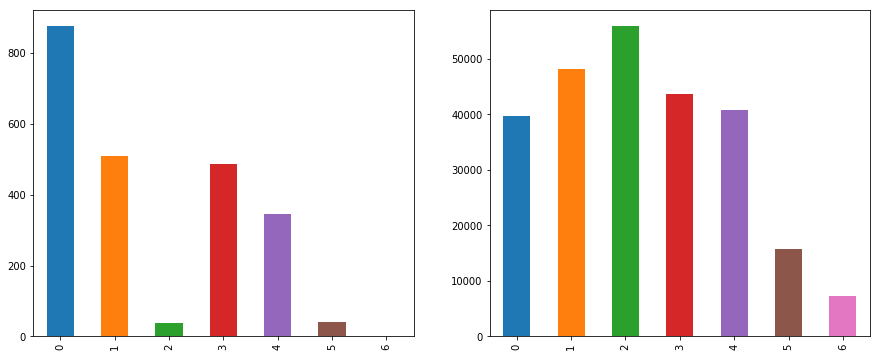

In [26]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
train_df[train_df['target']==1]['time1'].apply(lambda ts: ts.dayofweek).value_counts().sort_index().plot(kind='bar')
plt.subplot(1, 2, 2)
train_df[train_df['target']==0]['time1'].apply(lambda ts: ts.dayofweek).value_counts().sort_index().plot(kind='bar');

In [27]:
new_feat_train = pd.DataFrame(index=train_df.index)
new_feat_test = pd.DataFrame(index=test_df.index)

In [28]:
new_feat_train['day_of_week'] = train_df['time1'].apply(lambda ts: ts.dayofweek)
new_feat_test['day_of_week'] = test_df['time1'].apply(lambda ts: ts.dayofweek)

new_feat_train['start_hour'] = train_df['time1'].apply(lambda ts: ts.hour)
new_feat_test['start_hour'] = test_df['time1'].apply(lambda ts: ts.hour)

new_feat_train['day_of_month'] = train_df['time1'].apply(lambda ts: ts.day)
new_feat_test['day_of_month'] = test_df['time1'].apply(lambda ts: ts.day)

new_feat_train['weekend'] = new_feat_train['day_of_week'].apply(lambda ts: 1 if ts==5 or ts==6 else 0 )
new_feat_test['weekend'] = new_feat_test['day_of_week'].apply(lambda ts: 1 if ts==5 or ts==6 else 0 )

In [29]:
new_feat_train['lunch1'] = train_df['time1'].apply(lambda ts: 1 if ts.hour==14  else 0 )
new_feat_test['lunch1'] = test_df['time1'].apply(lambda ts: 1 if ts.hour==14  else 0 )

new_feat_train['lunch2'] = train_df['time1'].apply(lambda ts: 1 if ts.hour==15 else 0 )
new_feat_test['lunch2'] = test_df['time1'].apply(lambda ts: 1 if ts.hour==15 else 0 )

In [30]:
new_feat_train['eleven'] = train_df['time1'].apply(lambda ts: 1 if ts.hour==11 else 0 )
new_feat_test['eleven'] = test_df['time1'].apply(lambda ts: 1 if ts.hour==11 else 0 )

new_feat_train['nine'] = train_df['time1'].apply(lambda ts: 1 if ts.hour==9 else 0 )
new_feat_test['nine'] = test_df['time1'].apply(lambda ts: 1 if ts.hour==9 else 0 )

In [31]:
new_feat_train['morning'] = ((new_feat_train['start_hour'] >= 7) & (new_feat_train['start_hour'] <= 11)).astype('int')
new_feat_train['day'] = ((new_feat_train['start_hour'] >= 12) & (new_feat_train['start_hour'] <= 18)).astype('int')
new_feat_train['evening'] = ((new_feat_train['start_hour'] >= 19) & (new_feat_train['start_hour'] <= 23)).astype('int')
new_feat_train['night'] = ((new_feat_train['start_hour'] >= 0) & (new_feat_train['start_hour'] <= 6)).astype('int')

In [32]:
new_feat_test['morning'] = ((new_feat_test['start_hour'] >= 7) & (new_feat_test['start_hour'] <= 11)).astype('int')
new_feat_test['day'] = ((new_feat_test['start_hour'] >= 12) & (new_feat_test['start_hour'] <= 18)).astype('int')
new_feat_test['evening'] = ((new_feat_test['start_hour'] >= 19) & (new_feat_test['start_hour'] <= 23)).astype('int')
new_feat_test['night'] = ((new_feat_test['start_hour'] >= 0) & (new_feat_test['start_hour'] <= 6)).astype('int')

In [33]:
new_feat_train['first_week'] = ((new_feat_train['day_of_month'] >= 1) & (new_feat_train['day_of_month'] < 8)).astype(int)
new_feat_train['second_week'] = ((new_feat_train['day_of_month'] >= 8) & (new_feat_train['day_of_month'] < 15)).astype(int)
new_feat_train['third_week'] = ((new_feat_train['day_of_month'] >= 15) & (new_feat_train['day_of_month'] < 22)).astype(int)
new_feat_train['fourth_week'] = (new_feat_train['day_of_month'] >= 22).astype(int)

In [34]:
new_feat_test['first_week'] = ((new_feat_test['day_of_month'] >= 1) & (new_feat_test['day_of_month'] < 8)).astype(int)
new_feat_test['second_week'] = ((new_feat_test['day_of_month'] >= 8) & (new_feat_test['day_of_month'] < 15)).astype(int)
new_feat_test['third_week'] = ((new_feat_test['day_of_month'] >= 15) & (new_feat_test['day_of_month'] < 22)).astype(int)
new_feat_test['fourth_week'] = (new_feat_test['day_of_month'] >= 22).astype(int)

In [35]:
cl = ['day_of_week', 'lunch1', 'lunch2', 'eleven',
       'morning', 'day', 'evening', 'night', 'first_week', 'second_week',
       'third_week', 'fourth_week', 'nine']

In [36]:
new_feat_train.head()

,day_of_week,start_hour,day_of_month,weekend,lunch1,lunch2,eleven,nine,morning,day,evening,night,first_week,second_week,third_week,fourth_week
session_id,,,,,,,,,,,,,,,,
21669,5,8,12,1,0,0,0,0,1,0,0,0,0,1,0,0
54843,5,8,12,1,0,0,0,0,1,0,0,0,0,1,0,0
77292,5,8,12,1,0,0,0,0,1,0,0,0,0,1,0,0
114021,5,8,12,1,0,0,0,0,1,0,0,0,0,1,0,0
146670,5,8,12,1,0,0,0,0,1,0,0,0,0,1,0,0


In [37]:
scaler = StandardScaler()

train_scaled = scaler.fit_transform(new_feat_train[cl])
test_scaled = scaler.transform(new_feat_test[cl])

#### hstack
hstack объединяет разреженных матрицы, добавляет рядом к матрице другой столбец-матрицу. hstack надо импортировать

In [38]:
#сделали разреженную матрицу
X_train_sparse_new1 = csr_matrix(hstack([train_scaled, X_train_sites]))

In [39]:
%%time
logit = LogisticRegression(C=8, n_jobs=-1, random_state=17)
logit.fit(X_train_sparse_new1,y_train)

CPU times: user 36.3 s, sys: 320 ms, total: 36.6 s
Wall time: 19.2 s


In [40]:
train_and_predict(logit, X_train_sparse_new1,y_train)
#0.939

CV scores [0.92075755 0.85342808 0.83711218 0.96055751 0.94828439 0.96261014
 0.9115271  0.95112487 0.95975237 0.97768672]
CV mean: 0.9282840912181168, CV std: 0.045635099334480254


array([0.92075755, 0.85342808, 0.83711218, 0.96055751, 0.94828439,
       0.96261014, 0.9115271 , 0.95112487, 0.95975237, 0.97768672])

In [41]:
X_test_sparse_new1 = csr_matrix(hstack([test_scaled, X_test_sites]))

In [42]:
test_pred_new1 = logit.predict_proba(X_test_sparse_new1)[:,1]

In [43]:
#запишем результат в файл для отправки на kaggle
pd.Series(test_pred_new1, index=range(1, test_pred_new1.shape[0]+1), 
          name='target').to_csv('submitted.csv', header=True, index_label='session_id')

## EDA exploration data analisys

In [44]:
temp_df = new_feat_train.copy()
temp_df['target'] = train_df['target']
Alice_df = temp_df[temp_df['target']==1]
Not_Alice_df = temp_df[temp_df['target']==0]

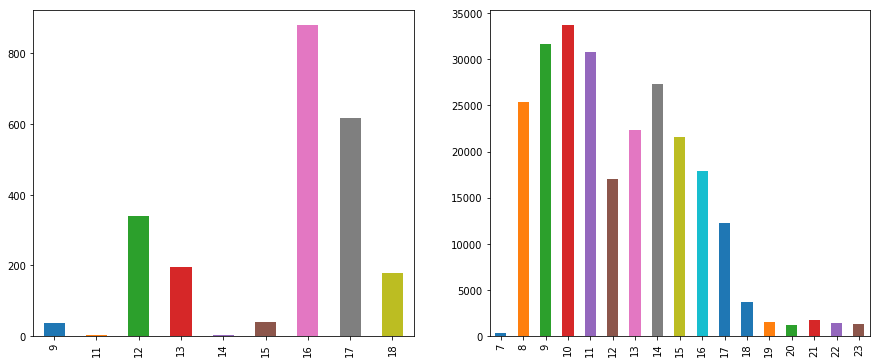

In [45]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
Alice_df['start_hour'].value_counts().sort_index().plot(kind='bar')
plt.subplot(1, 2, 2)
Not_Alice_df['start_hour'].value_counts().sort_index().plot(kind='bar');